# Stock time series analysis

I will be using the time series modelling techniques like ARIMA and Prophet to predict the stock price movement in future. I will be using Google stock price data for the following analysis

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Fetch historical data
ticker = 'GOOGL'
start_date = '2017-01-01'
end_date = '2019-12-31'
data = yf.download(ticker, start=start_date, end=end_date, interval='1D')
prices = data['Close']

# Prepare data
prices.index = pd.DatetimeIndex(prices.index)
prices = prices.asfreq('D')
if prices.isna().any():
    prices = prices.ffill()

# Split the data into training and test sets
train_size = int(len(prices) * 0.9)  # Use 90% of data for training
train_prices, test_prices = prices[:train_size], prices[train_size:]

# get log returns
returns = np.log(prices).diff()

# we can drop the days with no prices because we consider th
returns.dropna(inplace=True)

# split the data into train and test
split = int(len(returns.values) * 0.90)

price_train = prices.iloc[:split+1]
price_test = prices.iloc[split:]
return_train = returns.iloc[:split]
return_test = returns.iloc[split:]
print(return_test.shape,return_train.shape,price_test.shape,price_train.shape,prices.shape)


[*********************100%%**********************]  1 of 1 completed

(110,) (981,) (111,) (982,) (1092,)


Out exercises indicate that predicting stock prices with great precision is not possible using the ARIMA and prophet models.

<Axes: title={'center': 'GOOGL Stock Price'}, xlabel='Date', ylabel='Price'>

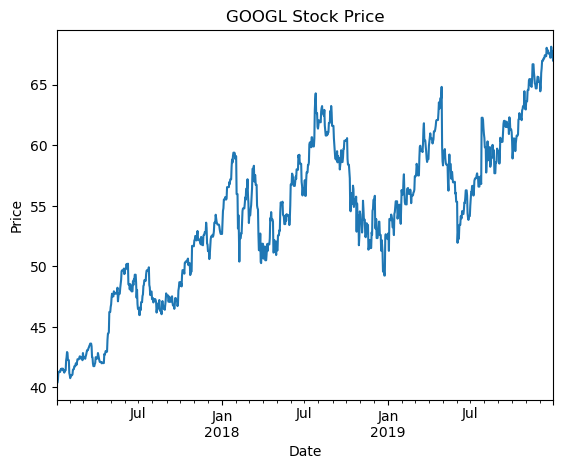

In [ ]:
prices.plot(title=f'{ticker} Stock Price',ylabel='Price',xlabel='Date')

<Axes: xlabel='Date'>

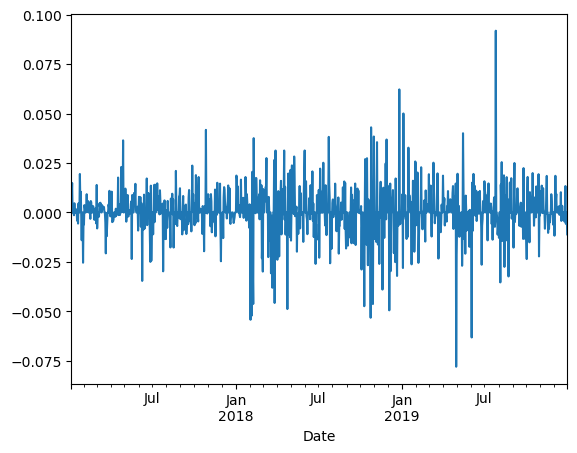

In [ ]:
returns.plot()

Returns look normally distributed

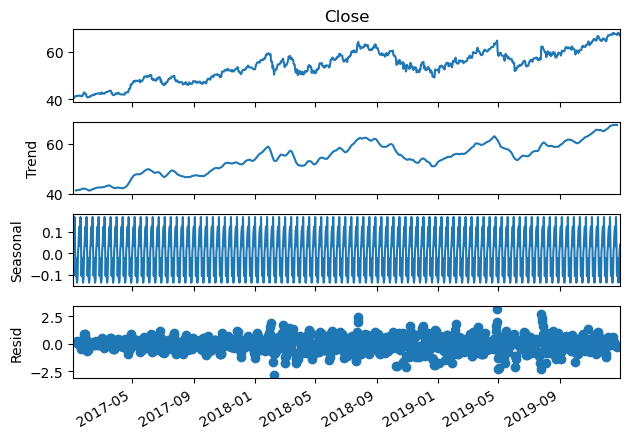

In [ ]:
# Plot  the components of a time series by
# seasonal_decompose function from statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(prices, period=12).plot()
plt.gcf().autofmt_xdate()
plt.show()

The stock prices does not show any long term seasonality which is expected as the stock prices of tech stocks are not known to show seasonality and are affected by news and new innovations.

## Stationarity 

Check the stationarity of returns using :

- Augmented Dickey-Fuller (ADF) Test
  - **Null Hypothesis (H₀)**: The time series has a unit root (i.e., it is **non-stationary**).
  - **Interpretation of p-value**: 
    - **Low p-value (≤ significance level, e.g., 0.05)**: Reject H₀, indicating the series is likely stationary.
    - **High p-value (> significance level)**: Fail to reject H₀, indicating the series is likely non-stationary.

- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
  - **Null Hypothesis (H₀)**: The time series is **stationary**.
  - **Interpretation of p-value**:
    - **Low p-value (≤ significance level, e.g., 0.05)**: Reject H₀, indicating the series is likely non-stationary.
    - **High p-value (> significance level)**: Fail to reject H₀, indicating the series is likely stationary.
  
-  Plots of the (partial) autocorrelation function (PACF/ACF)

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x):
    
    # run the test on x
    adf_test = adfuller(x, autolag="AIC")
    # create dataframe with adf_test results
    # fill first 4 indices
    indices = ["Test Statistic", "p-value", "No. of Lags Used", "No. of Observations Used"]
    results = pd.Series(adf_test[0:4], index=indices)
    
    # 4th item gives the dictionary containing critical values
    for key, value in adf_test[4].items():
        results[f"Critical Value {key}"] = value

    return results

test_results = adf_test(returns)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']<0.05:
    print("returns are stationary")
else:
    print("returns is not stationary")


test_results = adf_test(prices)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']<0.05:
    print("price are stationary")
else:
    print("price is not stationary")


Test Statistic : -13.404595757317981
p-value : 4.496369533762638e-25
No. of Lags Used : 7.0
No. of Observations Used : 1083.0
Critical Value 1% : -3.436402509014354
Critical Value 5% : -2.8642124318084456
Critical Value 10% : -2.568192893555997
returns are stationary
Test Statistic : -1.4087887916414035
p-value : 0.5780554839387231
No. of Lags Used : 8.0
No. of Observations Used : 1083.0
Critical Value 1% : -3.436402509014354
Critical Value 5% : -2.8642124318084456
Critical Value 10% : -2.568192893555997
price is not stationary


In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

def kpss_test(x, h0_type="c"):    
    
    # Apply KPSS test
    kpss_test = kpss(x, regression=h0_type)
    
    # create dataframe with kpss_test results
    indices = ["Test Statistic", "p-value", "No. of Lags"]
    
    results = pd.Series(kpss_test[0:3], index=indices)

    # 3th item gives the dictionary containing critical values
    for key, value in kpss_test[3].items():
        results[f"Critical Value {key}"] = value

    return results

test_results = kpss_test(returns)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']>0.05:
    print("returns are stationary")
else:
    print("returns are not stationary")

test_results = kpss_test(prices)

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']>0.05:
    print("prices are stationary")
else:
    print("prices are not stationary")


Test Statistic : 0.04658927157897807
p-value : 0.1
No. of Lags : 4.0
Critical Value 10% : 0.347
Critical Value 5% : 0.463
Critical Value 2.5% : 0.574
Critical Value 1% : 0.739
returns are stationary
Test Statistic : 4.101725145563903
p-value : 0.01
No. of Lags : 19.0
Critical Value 10% : 0.347
Critical Value 5% : 0.463
Critical Value 2.5% : 0.574
Critical Value 1% : 0.739
prices are not stationary


/tmp/ipykernel_564/4001710092.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(x, regression=h0_type)
/tmp/ipykernel_564/4001710092.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type)


Both the results show that the returns are stationary but the prices are not so we use returns in our analysis

## ACF and PCF

Auto-correlation functions (ACF) show the correlation between the same series with different lags. With h being the lag:

$ρ(h) = \frac{Cov(X_t , X_{t−h} )}{Var(X_t )}$

The coefficients help in deciding the q in MA(q) models.

Partial ACF (PACF) gives information on correlation between current value of a time series
and its lagged values controlling for the other correlations.

$ρ(h) = \frac{Cov(X_t ,X_{t−h} |X_{t−1} ,X_{t−2} ...X_{t−h−1})}{
\sqrt{Var(X_t |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )Var(X_{t−h} |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )}}$

The coefficients help in deciding the p in AR(p) models.


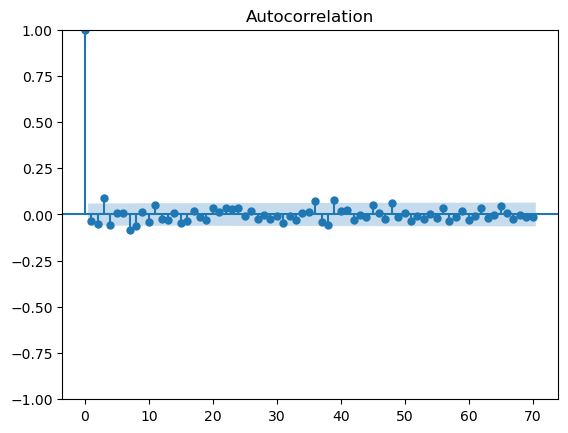

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(returns,lags=70)
plt.show()

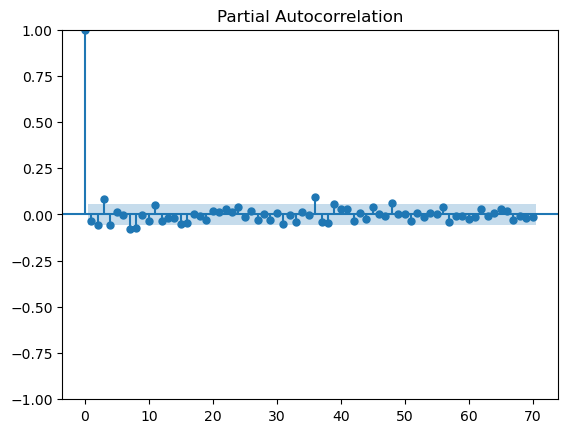

In [ ]:
sm.graphics.tsa.plot_pacf(returns,lags=70)
plt.show()

Both ACF and PACF show that the returns are stationary and do not have a correlation with the lagged values.

## Time Series modeling

### Moving Average (MA)

Moving average can be considered as smoothing model as it tends to take into account the lag
values of residual.

For $\alpha \ne 0$, MA(q) can be written as:

$X_t = \epsilon_t + \alpha_1 \epsilon_{t−1} + \alpha_2 \epsilon_{t−2} ... + \alpha_q \epsilon_{t−q}$


No Peak at in ACF, we choose them order for MA i.e. MA(0) Model

Transform back to prices

The model is a bad fit for the test data.

### Autoregressive Model

Idea is the current value is regressed over its own lag
values in this model. Forcast the current value of time series $X_{t}$:


$X_t = c + \alpha_1 X_{t−1} + \alpha_2 X_{t−2} ... + \alpha_p X_{t−p} + \epsilon_t$



### ARIMA Models

ARIMA models are a combination of three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). The advantage of intergration parameter is that is non-stationary data is used it can make it stationary by defining the integration parameter. 

Three parameters are to be defined p (dicussed above for AR), q (dicussed for MA) and d (control for level difference). d=1 is makes the model ARMA which is a limiting case of ARIMA (p,1,q) models but is also a good model given by:

$Xt = \alpha_1 dX_{t−1} + \alpha_2 dX_{t−2} ... + \alpha_p dX_{t−p} + \epsilon_t + \beta_1 d\epsilon_{t−1} + \beta_2 d\epsilon_{t−2} ... + \beta_q d\epsilon_{t−q}$

Pros
 - ARIMA allows us to work with raw data without considering if it is
stationary.
 - It performs well with high-frequent data.
It is less sensitive to the fluctuation in the data compared to other models.

Cons
 - ARIMA might fail in capturing seasonality.
 - It work better with a long series and short-term (daily, hourly) data.
 - As no automatic updating occurs in ARIMA, no structural break during the analysis period should be observed.
 - Having no adjustment in the ARIMA process leads to instability.


Choosing the parameters from for the ARIMA model. I choose the range 0-10 for the p and q and 0-3 for d.
Selection of the parameters for the model is made using Akaike Information Criterion (AIC). The parameters resulting in minimum value of AIC are selected. 

$AIC=2k−2ln(L)$

Where:
 - AIC is the Akaike Information Criterion.
 - k is the number of parameters in the model.
 - ln(L) is the natural logarithm of the likelihood of the model.




### Grid Search for parameters 

We perform a grid search to indentify the best parameters for the ARIMA model. The combination that gives minimum AIC is considered as the best model.

Best ARIMA order: (2, 1, 2) with AIC: 2022.59
Mean Squared Error: 16.20


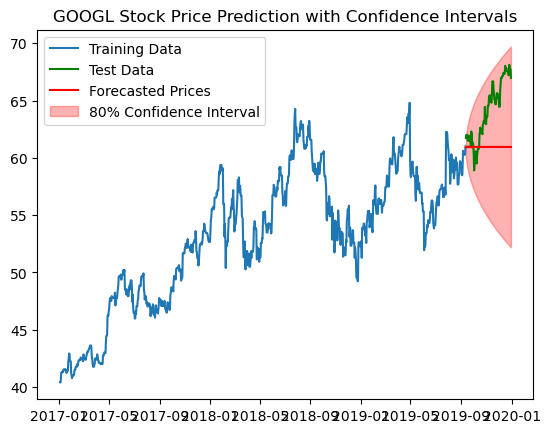

In [ ]:

# Grid search for best ARIMA(p, d, q) using AIC
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_aic = np.inf  # Initialize best AIC to infinity
best_order = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_prices, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
                # print(f'ARIMA{p,d,q} - AIC:{aic:.2f}')
            except Exception as e:
                print(f'Error with ARIMA{p,d,q}: {e}')
                continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')
# Forecast future values on the test set
forecast_result = best_model.get_forecast(steps=len(test_prices))
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int(alpha=0.2)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_prices, forecast_mean)
print(f'Mean Squared Error: {mse:.2f}')

# Plot the results
fig,ax = plt.subplots(1,1)
ax.plot(train_prices.index, train_prices, label='Training Data')
ax.plot(test_prices.index, test_prices, label='Test Data', color='green')
ax.plot(test_prices.index, forecast_mean, color='red', label='Forecasted Prices')

# Plot confidence intervals
ax.fill_between(test_prices.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.3, label='80% Confidence Interval')

ax.set_title(f'{ticker} Stock Price Prediction with Confidence Intervals')
ax.legend()
plt.show()


The best model according to grid search is ARIMA order: (2, 1, 2) with AIC: 2022.59
. Plotting the diagnosits of the ARIMA model 

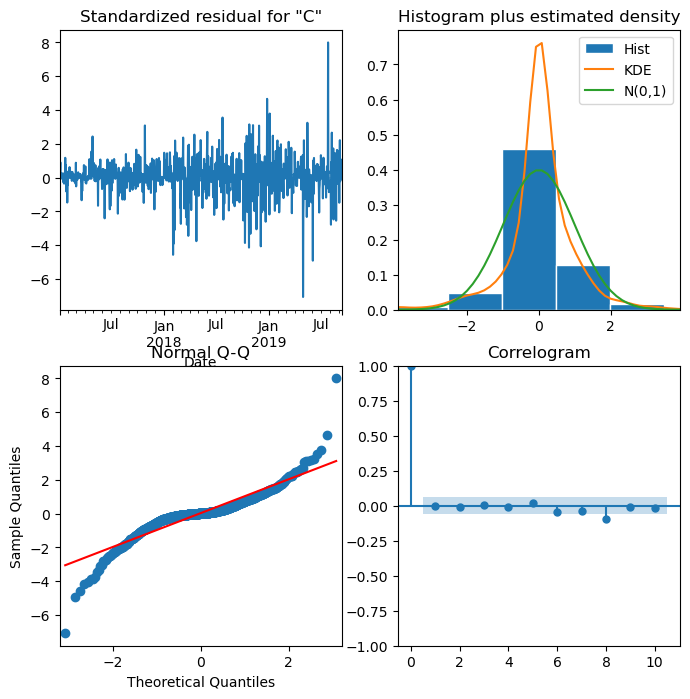

In [ ]:
best_model.plot_diagnostics(figsize=(8,8))
plt.show()

We observe that the ARIMA model does not do a good job of predicting the stock movement. It is not better than the naive model of using last training price as the prediction. 

### Auto ARIMA to find the best parameters

We can also use auto_arima function in pmdarima library to find the best parameters.

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(price_train, start_p=0, start_q=0,
            test='adf',       
            max_p=12, max_q=12,                        
            seasonal=True, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2033.257, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2034.048, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2033.911, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2032.190, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2032.601, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.864 seconds


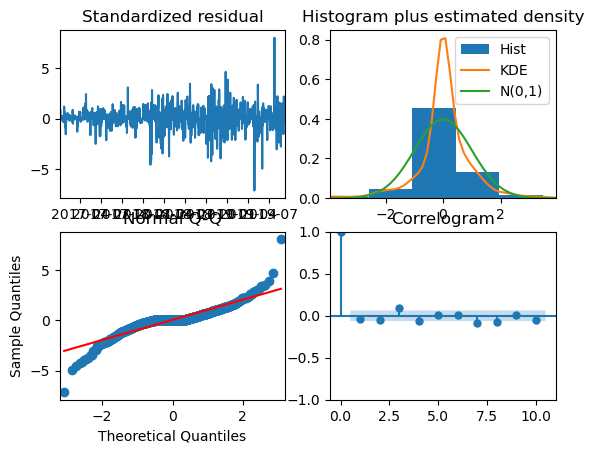

In [ ]:
# inspect residuals
model.plot_diagnostics()
plt.show()

Auto arima predicts that the best model is ARIMA(0,1,0) which means a combination of AR(0) and MA(0) model on returns. The AIC of the model is more than what we found for the grid search. 

In [ ]:
y_forec95, conf_int95  = model.predict(len(price_test),return_conf_int=True,alpha=0.05)
y_forec80, conf_int80  = model.predict(len(price_test),return_conf_int=True,alpha=0.2)


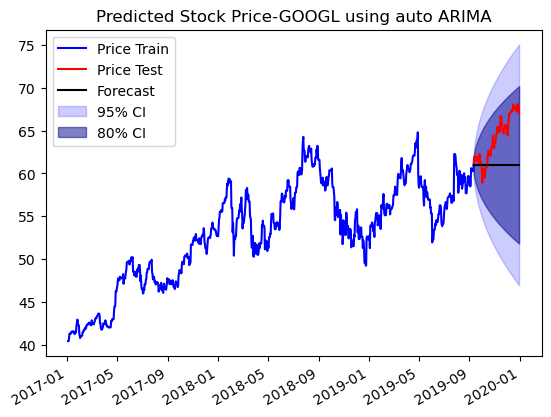

In [ ]:

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Price Train')
ax.plot(price_test.index,price_test.values,color='r',label='Price Test')
ax.plot(price_test.index,y_forec95,color='k',label='Forecast')
ax.fill_between(price_test.index,conf_int95[:,0],conf_int95[:,1],alpha=0.2,color='b',label='95% CI')
ax.fill_between(price_test.index,conf_int80[:,0],conf_int80[:,1],alpha=0.5,color='darkblue',label='80% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using auto ARIMA')
ax.legend(loc=2)
plt.gcf().autofmt_xdate()

The auto ARIMA model is not able to get a better job than the grid search. It does not capture the trend of the price movement. The prices lie within the 80% confidence interval but the model is just a naive model of using last training price as the prediction.

## Prophet 

The Prophet package, developed by Facebook, is a powerful tool for time series analysis, particularly designed for forecasting data that exhibits clear seasonal patterns and trends. Prophet uses an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, along with holiday effects. The model is robust to missing data and shifts in the trend.

The core of Prophet's methodology is the decomposition of a time series \( y(t) \) into three main components:

\[ y(t) = g(t) + s(t) + h(t) + \epsilon_t \]

- \( g(t) \): A piecewise linear or logistic growth trend.
- \( s(t) \): A periodic component representing seasonality.
- \( h(t) \): Holiday effects modeled using a set of user-supplied dates.
- \( \epsilon_t \): The error term, capturing random noise.

Prophet automatically identifies change points in the data where the trend shifts and adjusts the model accordingly, allowing it to handle time series with complex, non-linear trends effectively. It’s user-friendly and requires minimal tuning, making it an excellent choice for practitioners with varied levels of expertise in time series forecasting.

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


alldat = prices.to_frame().reset_index()

# preparing data for prophet
alldat.rename(columns={'Date':'ds','Close':'y'},inplace=True)

# test-train split
train_df, test_df = train_test_split(alldat, test_size=0.1, shuffle=False)

# model initialization
m = Prophet(daily_seasonality = False) # the Prophet class (model)
# fit model
m.fit(train_df)



20:47:41 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing


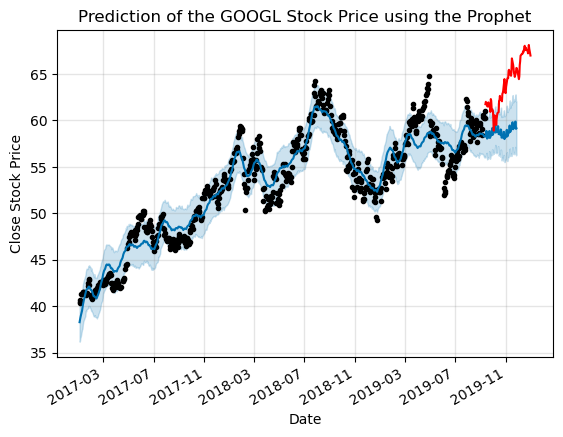

In [ ]:

future = m.make_future_dataframe(periods=test_df.shape[0]) #we need to specify the number of days in future

fig,ax = plt.subplots()
prediction = m.predict(future)
m.plot(prediction,ax=ax)
ax.set_title(f"Prediction of the {ticker} Stock Price using the Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Close Stock Price")
ax.plot(test_df['ds'],test_df['y'],color='r')
plt.gcf().autofmt_xdate()
plt.show()

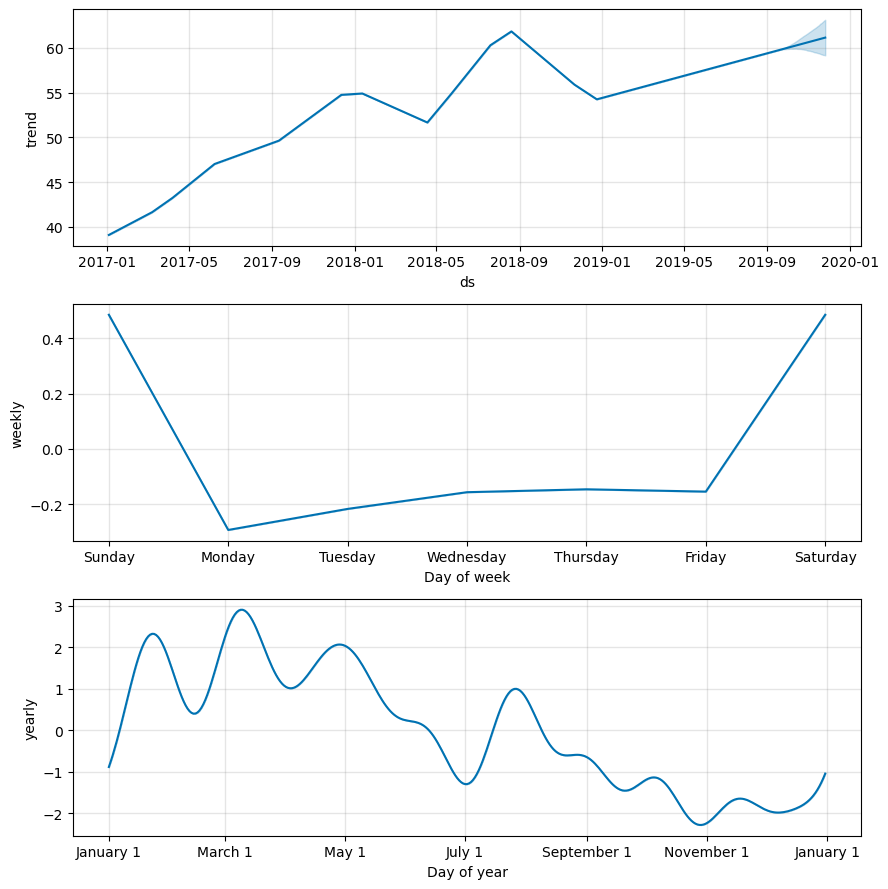

In [ ]:
m.plot_components(prediction)
plt.show()

Prophet does not to do a very good job for predicting the stock future movements out of the box. Prophet is designed for time series with clear trends and seasonality, so its application to stock prices (which are notoriously noisy and influenced by many factors) should be approached with caution.

Out exercises indicate that predicting stock prices with great precision is not possible using the ARIMA and prophet models.